## Profile likelihood method for detemining uncertaininty contributions in DM direct detection searches from uncertanity in local DM VDF of MW

In [1]:
import numpy as np 
import sys, pickle
import matplotlib.pyplot as plt

sys.path.append('../../')
from project.recoil.nuclear import Nuclear as Nr, p50, norm
from project.recoil.profilelikelihood import MLE
from project.recoil.profilelikelihood import StatisticalUncertanity as Stat 
from project.recoil.profilelikelihood import MassModelUncertanity as MassModel
from project.recoil.profilelikelihood import SampleUncertanity as Samp
from project.tools.plot_assist import multiline, truncate_colormap

import matplotlib
matplotlib.rcParams['font.family'] = 'sans'
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
matplotlib.rcParams['figure.figsize'] = (6,5)


In [2]:
MWlike = pickle.load(open('../../Output/MWlike_dict.pkl','rb'))
mwld = MWlike['vdf_RCfit']
mwd = mwld['MW']
mwgals = MWlike['gals']

In [3]:
nr_init = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1, Eroi=5.0, ω=10.0)
mock = nr_init.mocksample(4., 1e-45, 0.001, seed=5111)

In [4]:
stat = Stat(mock, nr_init, Mdm=np.linspace(3,5,50))
statlim = stat.get_limits(stat.Mdm)

In [5]:
mm = MassModel(mock, nr_init, Mdm=np.around(np.linspace(3,5,50),2), chainlen=100)
mmlim = mm.get_limits(mm.Mdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
samp = Samp(mock, nr_init, Mdm=np.linspace(2,5,100), run_parallel=True, percentiles=np.arange(5,95,0.1))
samplim = samp.get_limits(samp.Mdm)
# samplim_99 = samp.get_limits(samp.Mdm, tq_limit=9.21)

  0%|          | 0/900 [00:00<?, ?it/s]

Text(0, 0.5, '$\\sigma_p\\, \\mathrm{(cm)^2}$')

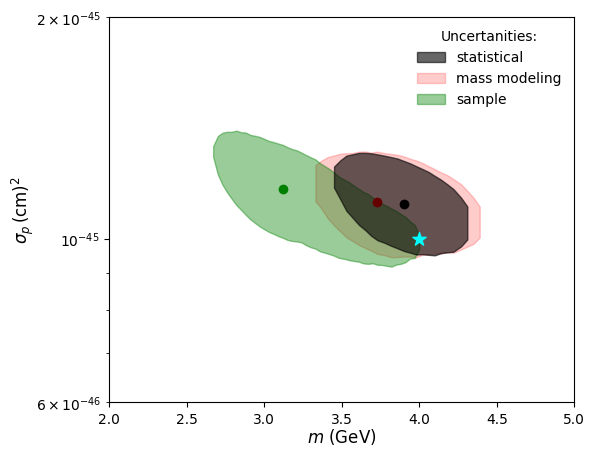

In [7]:
fig, ax = plt.subplots()
ax.fill_between(*statlim, color='k', alpha=0.6, label='statistical', zorder=2)
ax.fill_between(*mmlim, color='r', alpha=0.2, label='mass modeling', zorder=1)
ax.fill_between(*samplim, color='g', alpha=0.4, label='sample')
for mle, clr in zip([stat, samp, mm], ['k', 'g', 'r']):
    ax.scatter(mle.mdm_min, mle.sdm_min, c=clr, zorder=1)
ax.scatter(4., 1e-45, c='cyan', marker='*', s=100, zorder=2)
ax.legend(frameon=False, title='Uncertanities:')
ax.set_ylim(6e-46, 2e-45)
ax.set_xlim(2,5)
ax.set_yscale('log')
ax.set_xlabel('$m$ (GeV)', size=12, labelpad=0)
ax.set_ylabel('$\sigma_p\, \mathrm{(cm)^2}$', size=12, labelpad=0)
# plt.savefig('../../Output/figures/nuclear/uncertanities.png',bbox_inches='tight', dpi=300)

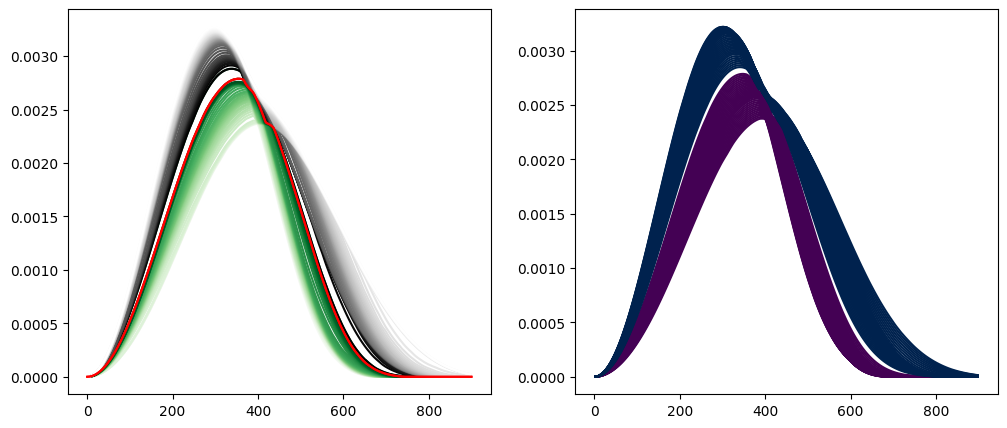

In [12]:
xs = [vE]*45
ys_1 = [np.percentile(VdfEs, per, axis=1) for per in np.linspace(5,50,45)]
ys_2 = [np.percentile(VdfEs, per, axis=1) for per in np.linspace(50,95,45)]

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax1, ax2 = axs

multiline(xs, ys_1, c=np.linspace(5,50,45), cmap='Greens', ax=ax1)
multiline(xs, ys_2, c=np.linspace(95,50,45), cmap='Greys', ax=ax1)
ax1.plot(vE, np.percentile(VdfEs, 49., axis=1), c='r')


ys_3 = [np.percentile(vdfEs, per, axis=1) for per in np.linspace(1,50,49)]
ys_4 = [np.percentile(vdfEs, per, axis=1) for per in np.linspace(50,99,49)]
c3 = np.linspace(5,50,49)
c4 = np.linspace(95,50,49)
c3 = np.ones(49)*1
c4 = np.ones(49)*1

multiline(xs, ys_3, c=c3, cmap='viridis', ax=ax2)
multiline(xs, ys_4, c=c4, cmap='cividis', ax=ax2)
ax1.plot(vE, np.percentile(VdfEs, 49., axis=1), c='r')

# for ax in axs:
#     for gal in mwgals:
#         ax.plot(mwld[gal]['vE'], mwld[gal]['vdfE_50'], c='b')

In [27]:
rp = pickle.load(open('../../Output/rate_prediction.pkl','rb'))

In [28]:
rp['sample'].keys()

dict_keys([5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.1, 17.2, 17.3, 17.4, 17.

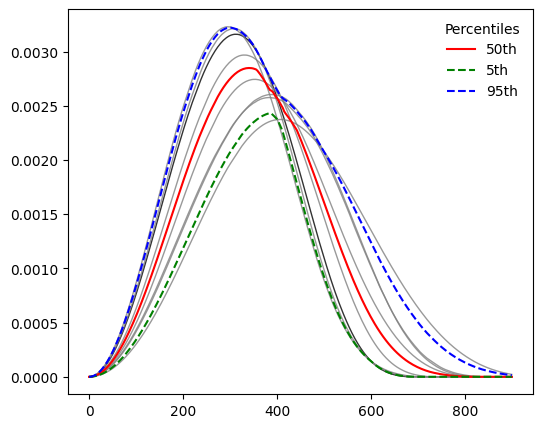

In [14]:
fig, ax = plt.subplots()
VdfEs = []
for gal in mwgals:
    vE = mwld[gal]['vE']
    vdfE = mwld[gal]['vdfE_50']
    if gal == 'MW':
        clr = 'k'
    else:
        clr = 'grey'
    ax.plot(vE, vdfE, c=clr, lw=1, alpha=0.8)
    VdfEs.append(vdfE)
VdfEs = np.array(VdfEs).T
vdfe = np.percentile(VdfEs, 50, axis=1)
ax.plot(vE, vdfe, c = 'r', label='50th')
vdfe = np.percentile(VdfEs, 5, axis=1)
ax.plot(vE, vdfe, c = 'g', ls='--', label='5th')
vdfe = np.percentile(VdfEs, 95, axis=1)
ax.plot(vE, vdfe, c = 'b', ls='--', label='95th')
vdfe = norm(vdfE, vE)
ax.legend(title='Percentiles', frameon=False);
plt.savefig('../../Output/figures/nuclear/vdf_percentiles.png', bbox_inches='tight', dpi=300)